### Database manifestação

#### Pré processamento

In [3]:
import spacy
import nltk

nltk.download('stopwords')

nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

def pre_processamento(texto):
    doc = nlp(texto)  # mantém caixa original

    tokens = []
    ent_by_start = {ent.start: ent for ent in doc.ents}

    i = 0
    while i < len(doc):
        if i in ent_by_start:
            ent = ent_by_start[i]
            ent_text = ent.text
            if ent_text.lower() not in stopwords:  # compara versão minúscula
                tokens.append(ent_text)
            i = ent.end
        else:
            token = doc[i]
            if token.is_alpha and token.text.lower() not in stopwords:
                tokens.append(token.text)
            i += 1

    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
import spacy
import nltk
from spacy.matcher import Matcher
from spacy.util import filter_spans

nltk.download('stopwords')

# Carrega modelo e stopwords
nlp = spacy.load('pt_core_news_lg')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

# Matcher para padrões como "20 mil pessoas"
matcher = Matcher(nlp.vocab)
padrao_cardinal_substantivo = [
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_num_extenso = [
    {"POS": "NUM"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
padrao_ordinal = [
    {"TAG": "ORD"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]
matcher.add("NUM_UNIDADE", [padrao_cardinal_substantivo, padrao_num_extenso, padrao_ordinal])

def pre_processamento(texto):
    doc = nlp(texto)

    # Identifica spans compostos (ex: "vinte mil pessoas")
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    # Mapeia início do span -> span para evitar tokenização duplicada
    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        if i in spans_dict:
            span = spans_dict[i]
            span_text = span.text
            if span_text.lower() not in stopwords:
                tokens.append(span_text)
            i = span.end
        elif i in ent_by_start:
            ent = ent_by_start[i]
            ent_text = ent.text
            if ent_text.lower() not in stopwords:
                tokens.append(ent_text)
            i = ent.end
        else:
            token = doc[i]
            if token.is_alpha and token.text.lower() not in stopwords:
                tokens.append(token.text)
            i += 1

    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Análise por notícia

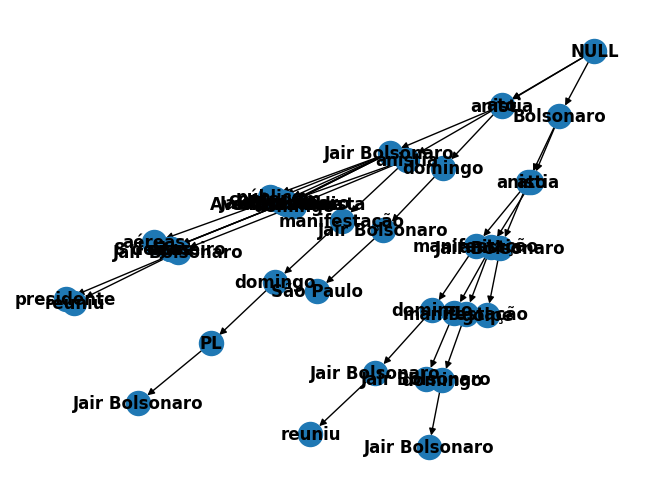

In [3]:
from trieofrules import trieofrules
import csv
import re

valores_coluna = []

with open('datasets/database_manifestacao_bolsonaro_pro_anistia.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      valores_coluna.append(line['Texto'])
      
valores = []
for texto in valores_coluna:
      result = pre_processamento(texto)
      valores.append(result)

#supported algorithms: FP-max, FP-growth, Apriori
TOR = trieofrules(data = valores, alg='FP-max', min_support=0.6) 
TOR.draw()
TOR.save_graph(filename = 'outputs/manifest_noticias.graphml') 

In [5]:
print('Sequências frequentes:')
for i in TOR.frequent_sequences:
    print(i)

print('\nTermos frequentes:')
for i in TOR.frequent_items:
    print(i)

Sequências frequentes:
{'apoio', 'Jair Bolsonaro', 'anistia'}
{'Jair Bolsonaro', 'anistia', 'ato', 'imagens', 'Bolsonaro'}
{'Jair Bolsonaro', 'envolvidos', 'anistia', 'defesa', 'ato'}
{'Jair Bolsonaro', 'pessoas', 'anistia', 'decisão', 'ato'}
{'Jair Bolsonaro', 'domingo', 'anistia', 'menos', 'ato'}
{'anistia', 'Jair Bolsonaro', 'Bolsonaro', 'mesma'}
{'Jair Bolsonaro', 'reuniu', 'manifestação', 'Bolsonaro', 'pessoas', 'domingo', 'anistia', 'momento'}
{'Jair Bolsonaro', 'domingo', 'anistia', 'governadores', 'manifestação'}
{'Jair Bolsonaro', 'domingo', 'PL', 'manifestação', 'Bolsonaro', 'pessoas', 'partir', 'anistia', 'ato'}
{'Jair Bolsonaro', 'mil', 'USP', 'aéreas', 'pessoas', 'contagem', 'anistia', 'ato'}
{'Jair Bolsonaro', 'mil', 'fotos', 'domingo', 'reuniu', 'aéreas', 'pessoas', 'contagem', 'anistia', 'ato'}
{'Jair Bolsonaro', 'pessoas', 'domingo', 'anistia', 'presentes', 'manifestação', 'Bolsonaro'}
{'Jair Bolsonaro', 'pessoas', 'Supremo Tribunal Federal', 'anistia', 'ato'}
{'Jair B

#### Análise por parágrafo

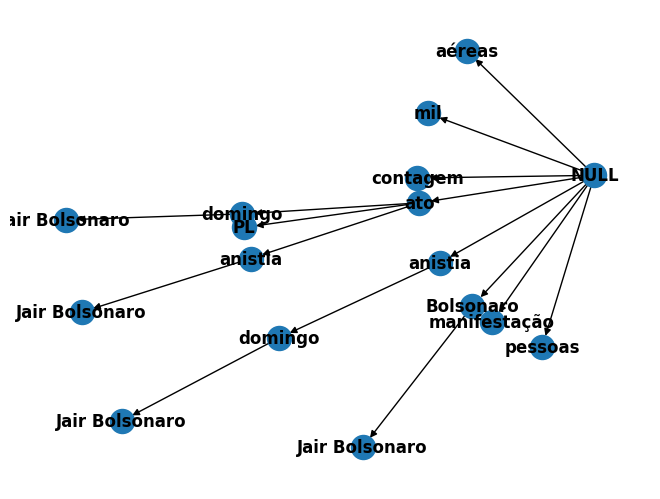

In [40]:
from trieofrules import trieofrules
import csv
import re

valores_coluna = []

with open('datasets/database_manifestacao_bolsonaro_pro_anistia.csv', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for line in reader:
      for paragragh in line['Texto'].split('\n\n\n'):
            valores_coluna.append(paragragh)
      
valores = []
for texto in valores_coluna:
      result = pre_processamento(texto)
      valores.append(result)

#supported algorithms: FP-max, FP-growth, Apriori
TOR = trieofrules(data = valores, alg='FP-max', min_support=0.3) 
TOR.draw()
TOR.save_graph(filename = 'outputs/manifest_paragrafos.graphml') 

In [41]:
print('Sequências frequentes:')
for i in TOR.frequent_sequences:
    print(i)

print('\nTermos frequentes:')
for i in TOR.frequent_items:
    print(i)

Sequências frequentes:
{'PL', 'ato'}
{'aéreas'}
{'mil'}
{'contagem'}
{'domingo', 'ato', 'Jair Bolsonaro'}
{'domingo', 'anistia', 'Jair Bolsonaro'}
{'Bolsonaro', 'Jair Bolsonaro'}
{'ato', 'anistia', 'Jair Bolsonaro'}
{'manifestação'}
{'pessoas'}

Termos frequentes:
Bolsonaro
pessoas
ato
mil
anistia
manifestação
domingo
PL
Jair Bolsonaro
contagem
golpe
janeiro
São Paulo
público
reuniu
condenados
disse
imagens
aéreas
atos
governadores
fotos
neste
STF
tentativa
USP
durante
prisão
